#### Using WIN M1 Metatrader 5 data

Implementing Saulo's arbitrage algo

The idea is to train a guided system that learns and ajusts itself with its owns errors.  
That's the idea of a kalman's filter.   
The base for the first decision is the Bollinger Bands Algo.  
That's the most powerfull algo, based on the regression toward the mean law!

In [1]:
%matplotlib inline 

In [2]:
cd stocks

[WinError 2] O sistema não pode encontrar o arquivo especificado: 'stocks'
C:\Users\alferreira\Documents\stocks\prototypes


In [3]:
cd ..

C:\Users\alferreira\Documents\stocks


In [4]:
from matplotlib import pyplot as plt
import os
import sys
import pandas as pd
import numpy as np
import struct
import datetime
import calendar
import time
import argparse
import seaborn as sns
from algos import meta5Ibov
from algos.util import progressbar
from algos import meta5Ibov, bbands3, bbands2
import importlib

#import torch as th
import scipy
import talib as ta
from numba import jit

In [5]:
importlib.reload(bbands3)
importlib.reload(bbands2)

<module 'algos.bbands2' from 'C:\\Users\\alferreira\\Documents\\stocks\\algos\\bbands2.py'>

In [6]:
cd data

C:\Users\alferreira\Documents\stocks\data


In [7]:
pwd

'C:\\Users\\alferreira\\Documents\\stocks\\data'

In [8]:
meta5Ibov.setDataPath(r'C:\\Users\\alferreira\\Documents\\stocks\\data', 
                      r'C:\\Users\\alferreira\\Documents\\stocks\\data')
# meta5Ibov.setDataPath(r'/home/andre/Projects/stocks/data', 
#                         r'/home/andre/Projects/stocks/data')

Master data loaded size (minutes):  509471
symbols loaded:
['ABEV3' 'B3SA3' 'BBAS3' 'BBDC4' 'DOL$' 'ITUB4' 'PETR4' 'VALE3' 'WIN@']


In [9]:
from scipy.stats import entropy as stat_entropy

def entropy(labels, base=3): # base 3 because of 3 classes
    value,counts = np.unique(labels, return_counts=True)
    return stat_entropy(counts, base=base)

## Real back-testing using normalized data for the previsou 5k minutes

In [10]:
cd ..

C:\Users\alferreira\Documents\stocks


In [11]:
from sklearn import metrics

In [12]:
from matplotlib import pyplot as plt
import os
import sys
import pandas as pd
import numpy as np
import struct
import datetime
import calendar
import time
import argparse
import seaborn as sns
from algos import meta5Ibov
from algos.util import progressbar
from algos import meta5Ibov, bbands3, bbands2
from sklearn.ensemble import ExtraTreesClassifier
import scipy
import talib as ta
from numba import jit


def predictProb(X, y, Xp):
    """dont predict if training vectors dont have 3 classes"""
    ypred = None
    try:
        trees = ExtraTreesClassifier(n_estimators=100, verbose=0)
        if len(np.unique(y)) == 3:
            trees.fit(X, y)
            ypred = trees.predict_proba(Xp)                                  
    except Exception as e:
        print(e, file=sys.stderr)   
    return ypred, trees 

def predictY(X, y, Xp):
    """dont predict if training vectors dont have 3 classes"""
    ypred = None
    try:
        trees = ExtraTreesClassifier(n_estimators=100, verbose=0)
        if len(np.unique(y)) == 3:
            trees.fit(X, y)
            ypred = trees.predict(Xp)
    except Exception as e:
        print(e, file=sys.stderr)   
    return ypred

def getTrainVectors(obars, window, nbands, batchn):
    # create target classes for the first piece of data
    bars = bbands3.barsTargetFromSignals(obars, window, nbands)   
    # standardize this slice of data
    isgfeatures, bars = bbands3.standardizeFeatures(bars, nbands)  
    # training vectors
    X, y, time = bbands3.getTrainingVectors(bars, isgfeatures, window, nbands, batchn)    
    return X, y, time

def crosScore(obars, window, nbands, batchn, twindow, Xscore, yscore, wscore):
    """validation or score is made on `length` wscore"""
    size = len(obars)
    # make 1 predictions for cross-validation
    X, y, idxtime = getTrainVectors(obars, window, nbands, batchn)
    ypred = predictY(X[-twindow:size-wscore], y[-twindow:size-wscore], Xscore)    
    # unfortunantly cannot analyse performance without real data
    if ( not np.isin(1, yscore) ) or (ypred is None): 
        return np.nan    
    ypred[ ypred == 2] = -1
    print(idxtime[-twindow:size-wscore], y[-twindow:size-wscore])    
    print(yscore, ypred)    
    cm = metrics.confusion_matrix(yscore, ypred) # score is precision of class 1
    if cm.shape[0] < 3:
        return np.nan
    score = cm[2, 2]/sum(cm[:, 2]) # tp/(tp+fp)
    return score

# training window latest data he used 80 latest signals
def predictMinute(obars, window, nbands, batchn, twindow, itime):
    ypred = [np.nan]*3 # prediction probabilites for each class
    features = [np.nan]*5 # feature to help divide between good and bad predictions
    
    signal = bbands3.lastSignal(obars, nbands)
    meta5time = pd.Timestamp(obars.index.values[-1])    
       
    if np.all(signal==0): # no entry point
        signal =  sumdPred(signal)
        return (*features, meta5time, itime, *[1, 0, 0], signal[0])        
    signal =  sumdPred(signal)
    
    # the truth vector is in here for the training set 
    bars = bbands3.barsTargetFromSignals(obars, window, nbands) 
    # standardize this slice of data
    # isgfeatures, bars = bbands3.standardizeFeatures(bars, nbands)
    
    X, y, time = bbands2.getTrainingVectors(bars, window, nbands, batchn)    
    Xp = bbands2.getForecastVector(bars, window, nbands, batchn)
    
    # cross validate using last twindow sam
    # the twindow might seam big but the ideal is to get 
    # an average  number of the model precision
#     wscore = 3
#     iys = ['y'+str(i) for i in range(nbands)] 
#     yscore = sumdPred(bars[iys])[-wscore:]
#     Xscore = X[-wscore:]
#     assert len(Xscore) == len(yscore)
    #score = crosScore(obars, window,nbands, batchn, twindow, Xscore, yscore, wscore)
    
    # now predict indeed
    predy, tmodel = predictProb(X[-twindow:], y[-twindow:], Xp.reshape(1, -1))
    
    if not predy is None:        
        ypred = predy[0] # just one prediction    
        # model score allways 1 over training data set, need something else
        m_score = tmodel.score(X[-2*twindow:], y[-2*twindow:]) # harsh but what we have
        feature_importances = tmodel.feature_importances_
        nusefull = len((feature_importances[feature_importances > 0.01]))

        indicator, n_nodes_ptr = tmodel.decision_path(Xp.reshape(1, -1))
        # which nodes are reached by this sample Xp
        # a # Return a node indicator matrix where non zero elements 
        # indicates that the samples goes through the nodes.
        # print(a.shape)  changes every fit
        
        # feature to help divide between good and bad predictions
        features = [entropy(y[-twindow:]), 
                    entropy(np.clip(feature_importances, 0.01, 1.), base=None), 
                    nusefull, 
                    indicator.shape[1],
                    m_score] 
    return (*features, meta5time, itime, *ypred, signal[0])

In [18]:
meta5Ibov.symbols

0    ABEV3
1    B3SA3
2    BBAS3
3    BBDC4
4     DOL$
5    ITUB4
6    PETR4
7    VALE3
8     WIN@
dtype: object

In [219]:
loaded = meta5Ibov.loadMeta5Data(suffix='M1.mt5bin',
            cleandays=False, preload=False, verbose=False)
barsread = meta5Ibov.getSymbol('ITUB4')

In [220]:
#barsread = barsread[-20000:]

He used 80 training samples (or signals)  
Window of 180 and batchn of 180  

Considering the 16/21 window
I think 8 signals are enough for training as long as we have 3 classes. 
Trying to recall the times I traded using Bollinger Bands. 
But should check time between signals.

- The fact that you are training with few data may create fit over patterns that are not justified. You are overfitting too locally


In [221]:
nbands=6
window=16
batchn=8 # previous samples of signals to store 
twindow=16

In [222]:
### 180 batch size, window 180 

In [223]:
bars = bbands3.barsRawSignals(barsread, window, nbands)
bars = bbands2.dayFeatures(bars)

In [37]:
bars.head(2)

,O,H,L,C,TV,S,RV,OHLC,bandlw0,bandup0,...,bandup3,bandsg3,bandlw4,bandup4,bandsg4,bandlw5,bandup5,bandsg5,date,dated
time,,,,,,,,,,,,,,,,,,,,,
2014-01-02 10:57:00,79100.0,79154.0,79100.0,79146.0,950,1,246,79125.00,79012.986156,79434.201344,...,79672.238142,0,79166.051129,79728.548871,0,79070.943499,79987.681501,0,16072,1
2014-01-02 10:58:00,79146.0,79193.0,79131.0,79193.0,1000,1,249,79165.75,79014.161928,79384.275572,...,79670.162239,1,79156.074571,79708.825429,1,79069.866816,79950.424850,0,16072,1


In [38]:
bars.columns

Index(['O', 'H', 'L', 'C', 'TV', 'S', 'RV', 'OHLC', 'bandlw0', 'bandup0',
       'bandsg0', 'bandlw1', 'bandup1', 'bandsg1', 'bandlw2', 'bandup2',
       'bandsg2', 'bandlw3', 'bandup3', 'bandsg3', 'bandlw4', 'bandup4',
       'bandsg4', 'bandlw5', 'bandup5', 'bandsg5', 'date', 'dated'],
      dtype='object')

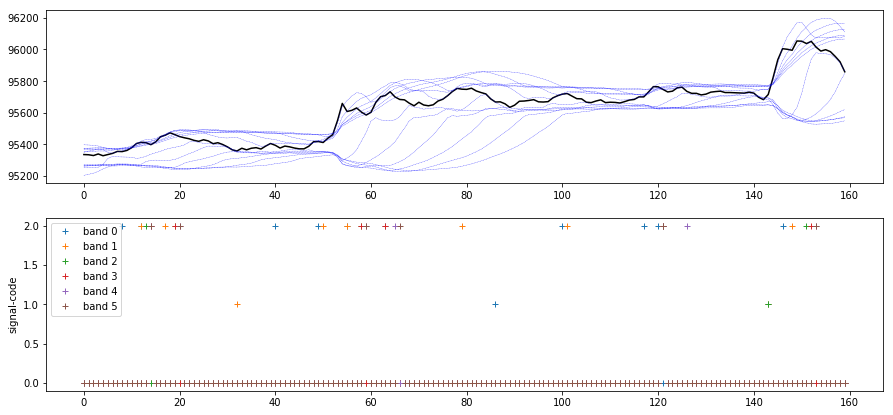

In [39]:
bbands3.viewBands(bars, nbands=nbands, lastn=-160)

In [40]:
# the truth vector is in here
truthbars = bbands3.barsTargetFromSignals(bars, window, nbands) 

In [41]:
truthbars.columns

Index(['O', 'H', 'L', 'C', 'TV', 'S', 'RV', 'OHLC', 'bandlw0', 'bandup0',
       'bandsg0', 'bandlw1', 'bandup1', 'bandsg1', 'bandlw2', 'bandup2',
       'bandsg2', 'bandlw3', 'bandup3', 'bandsg3', 'bandlw4', 'bandup4',
       'bandsg4', 'bandlw5', 'bandup5', 'bandsg5', 'date', 'dated', 'y0', 'y1',
       'y2', 'y3', 'y4', 'y5'],
      dtype='object')

In [45]:
nmax = len(bars)

In [46]:
nmax

509424

In [47]:
nsamples = 40000
datawindow = window*10 # 160 minutes okay I guess

In [48]:
datawindow

160

In [106]:
i = np.random.randint(datawindow, nmax)

In [107]:
predictMinute(bars[i-datawindow:i].copy(), window, nbands, batchn, twindow, i-1)

(0.9755307720176264,
 0.8772745944503839,
 31,
 1370,
 1.0,
 Timestamp('2015-07-29 16:33:00'),
 151352,
 0.19,
 0.18,
 0.63,
 -1)

In [74]:
%%time
import joblib

if __name__ == '__main__': # using backend="multiprocessing" solves the serialization problem on Linux
    results = joblib.Parallel(n_jobs=36, verbose=5)(
    joblib.delayed(predictMinute)(bars[i-datawindow:i].copy(), window, nbands, batchn, twindow, i-1)
    for i in np.random.randint(datawindow, nmax, nsamples))

[Parallel(n_jobs=36)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=36)]: Done  90 tasks      | elapsed:    4.9s
[Parallel(n_jobs=36)]: Done 216 tasks      | elapsed:    6.0s
[Parallel(n_jobs=36)]: Done 378 tasks      | elapsed:    7.2s
[Parallel(n_jobs=36)]: Done 576 tasks      | elapsed:    8.6s
[Parallel(n_jobs=36)]: Done 810 tasks      | elapsed:   10.4s
[Parallel(n_jobs=36)]: Done 1080 tasks      | elapsed:   12.4s
[Parallel(n_jobs=36)]: Done 1386 tasks      | elapsed:   14.6s
[Parallel(n_jobs=36)]: Done 1728 tasks      | elapsed:   17.2s
[Parallel(n_jobs=36)]: Done 2106 tasks      | elapsed:   20.1s
[Parallel(n_jobs=36)]: Done 2520 tasks      | elapsed:   23.1s
[Parallel(n_jobs=36)]: Done 2970 tasks      | elapsed:   26.3s
[Parallel(n_jobs=36)]: Done 3456 tasks      | elapsed:   29.9s
[Parallel(n_jobs=36)]: Done 3978 tasks      | elapsed:   33.8s
[Parallel(n_jobs=36)]: Done 4536 tasks      | elapsed:   37.9s
[Parallel(n_jobs=36)]: Done 5130 tasks      | 

Wall time: 5min 3s


[Parallel(n_jobs=36)]: Done 40000 out of 40000 | elapsed:  5.1min finished


#### Random Search of params 

What best gives precision on class 1

 - `tsignals` are crossing signals **ajdusted** for correct class (hold or buy or sell) number of training vectors
 - `bbwindow` size of second bb window. Others are multiples e. g. 
     [ 21, 21x0.5=10, 21x1.5=31, 21x2=42 etc ]
 - `nsamples` number of simulations to get that precision
 - `entries` number of 1 class per minute in %
 - `mtprec` metatrader 5 precision using predictions with this configuration
 - `support` number of samples classified as 1 for that clip-probabilities cut-off


 | batchn | nbands | bbwindow | tsignals |   g.prec.  | clip-pb.  |  nsamples  |  entries  |  mtprec |  symbol  | support |
 | ------ | ------ | -------- | -------  | ---------- | --------- | ---------- | --------- | ------- | -------- | ------- | 
 |   8    |    6   |    16    |    16    |     24%    |     -     |  40k-all   |     -     |    -    |  PETR4   |   103   |
 |   8    |    6   |    16    |    16    |     25%    |   tree    |  40k-all   |     -     |    -    |  PETR4   |    95   |
 |   8    |    6   |    16    |    16    |     25%    |   tree    |   40k-all  |     -     |    -    |   WIN@   |   141   |
 |   8    |    6   |    16    |    16    |     36%    |   .53     |   10k-all  |     -     |    -    |   WIN@   |         |
 |   8    |    6   |    16    |     8    |     37%    |   .52     |   10k-all  |     -     |    -    |   WIN@   |    3    |
 |   8    |    6   |    16    |     8    |    25%     |     -     |  80k-all   |    -      |    -    |  ITUB4   |    -    | 
 |   8    |    6   |    16    |     8    |    23%     |     -     |  30k-all   |    -      |    -    |  ITUB4   |    -    | 
 |   8    |    6   |    16    |     8    |    26%     |     -     |    all     |    -      |    -    |  ITUB4   |  5244   |
 |   8    |    6   |    16    |     8    |    49%     |   tree    |    all     |   0.03%   |    -    |  ITUB4   |   181   |
 
 - cannot test with few less samples than 30k. Even that might give an uncertainty of ~3%
 - cannot evaluate with few samples as support
 
 - global precision average means almost nothing since it certainly is diluted with all wrong predictions. 
 - cross validation is a must! long delayed!!

In [44]:
i = np.random.randint(datawindow, nmax)

In [26]:
%prun predictMinute(bars[i-datawindow:i].copy(), window, nbands, batchn, twindow, i-1)

In [27]:
%%timeit
predictMinute(bars[i-datawindow:i].copy(), window, nbands, batchn, twindow, i-1)

1.56 ms ± 151 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
%%time
results = []
for i in progressbar(np.random.randint(datawindow, nmax, nsamples)):
    results.append(predictMinute(bars[i-datawindow:i].copy(), window, nbands, batchn, twindow, i-1))

#### Once features are created by  `barsFeatured` no row is deleted. 
Then we can get the ytrue for any prediction if you know the index.  
Each band y class that had a signal will have a classification for this signal.  

In [86]:
# cd data/

In [677]:
##predics = pd.read_pickle('all_predictions_p80_70estimators_maxfeatures_300.pickle')

In [108]:
predics = pd.DataFrame(results, columns=['entrty', 'entrfeat', 'nfeat_1pc','decisionn','mscore', 
                                         'time', 'itime', 'y0', 'y1', 'y2', 'signal'])
predics.set_index('time', drop=True, inplace=True)
predics.dropna(inplace=True)

In [109]:
predics.head()

,entrty,entrfeat,nfeat_1pc,decisionn,mscore,itime,y0,y1,y2,signal
time,,,,,,,,,,
2018-03-23 10:26:00,0.669592,0.976544,35.0,1030.0,1.000000,425185,0.03,0.10,0.87,1
2017-06-19 11:58:00,0.946395,0.613408,23.0,750.0,1.000000,344306,0.00,0.08,0.92,0
2018-06-15 15:04:00,0.975531,0.821312,29.0,1542.0,0.750000,448408,0.05,0.17,0.78,0
2017-10-11 14:15:00,0.932020,0.821312,29.0,1264.0,1.000000,376856,0.03,0.12,0.85,0
2018-02-20 10:18:00,0.975531,0.849305,30.0,1100.0,0.863636,415045,0.43,0.35,0.22,3


In [110]:
#predics = predics[:4000]

In [113]:
ypred = sumyProb(predics[['y0', 'y1', 'y2']].values)
yprob = np.max(predics[['y0', 'y1', 'y2']].values, axis=-1)

In [114]:
predics['yprob'] = yprob
predics['ypred'] = ypred

In [115]:
#plt.hist(predics.score);

In [116]:
#predics = predics[predics.score > 0.02]

In [117]:
predics.head()

,entrty,entrfeat,nfeat_1pc,decisionn,mscore,itime,y0,y1,y2,signal,yprob,ypred
time,,,,,,,,,,,,
2018-03-23 10:26:00,0.669592,0.976544,35.0,1030.0,1.000000,425185,0.03,0.10,0.87,1,0.87,-1
2017-06-19 11:58:00,0.946395,0.613408,23.0,750.0,1.000000,344306,0.00,0.08,0.92,0,0.92,-1
2018-06-15 15:04:00,0.975531,0.821312,29.0,1542.0,0.750000,448408,0.05,0.17,0.78,0,0.78,-1
2017-10-11 14:15:00,0.932020,0.821312,29.0,1264.0,1.000000,376856,0.03,0.12,0.85,0,0.85,-1
2018-02-20 10:18:00,0.975531,0.849305,30.0,1100.0,0.863636,415045,0.43,0.35,0.22,3,0.43,0


In [118]:
len(results)

40000

In [119]:
len(predics.dropna())

6661

In [120]:
ypred = predics.ypred.copy()

In [121]:
percentries = len(ypred[ypred > 0])/(len(predics))

In [122]:
# per day entries
percentries

0.08557273682630236

In [123]:
percentries*60*7

35.94054946704699

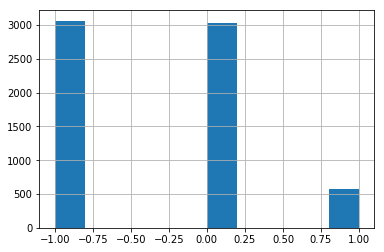

In [124]:
ypred.hist()

In [196]:
predics_clip = predics.copy()

In [182]:
predics_clip = predics.query("yprob > 0.5 and entrty > 0.8 and entrty < 0.95") # yprob > 0.51 and

<Figure size 432x288 with 0 Axes>

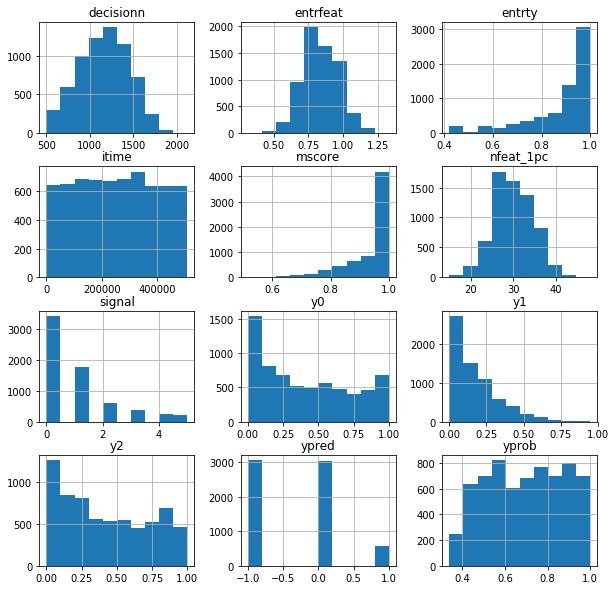

In [197]:
plt.figure()
predics_clip.hist(figsize=(10,10));

In [198]:
predics_clip = predics_clip[ predics_clip.ypred > 0 ]

In [199]:
np.unique(predics_clip.signal)

array([0, 1, 2, 3, 4, 5], dtype=int64)

In [200]:
#predics_clip = predics_clip.query("entrty > 0.75 and entrty < 0.9") # yprob > 0.51 and

In [201]:
iys = ['y'+str(i) for i in range(nbands)]
# the truth vector is in here
ys = sumdPred(truthbars[iys])
ys = ys.iloc[predics_clip.itime] # summarized prediction

In [202]:
predics_clip.ypred.unique()

array([1], dtype=int64)

In [203]:
ys.unique(), len(ys)

(array([1., 0.]), 570)

In [204]:
print(metrics.classification_report(ys, predics_clip.ypred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       429
         1.0       0.25      1.00      0.40       141

   micro avg       0.25      0.25      0.25       570
   macro avg       0.12      0.50      0.20       570
weighted avg       0.06      0.25      0.10       570



C:\Users\alferreira\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\alferreira\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\alferreira\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [205]:
len(predics_clip[ predics_clip.ypred > 0 ] )

570

In [206]:
100*len(predics_clip[ predics_clip.ypred > 0 ] )/nsamples

1.425

Turning in One vs All 

In [207]:
ys[ ys == -1 ] = 0

Fitting over predictions said where 1

In [208]:
len(ys), len(predics_clip)

(570, 570)

In [209]:
trees = ExtraTreesClassifier(n_estimators=10)

In [210]:
trees.fit(predics_clip.iloc[:150, :-1], ys[:150])

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [211]:
predics.columns

Index(['entrty', 'entrfeat', 'nfeat_1pc', 'decisionn', 'mscore', 'itime', 'y0',
       'y1', 'y2', 'signal', 'yprob', 'ypred'],
      dtype='object')

In [212]:
trees.feature_importances_

array([0.09513321, 0.08037071, 0.07978324, 0.09666922, 0.06306039,
       0.08486962, 0.10918631, 0.07792241, 0.12263595, 0.08524419,
       0.10512475])

In [213]:
trees.score(predics_clip.iloc[150:, :-1], ys[150:])

0.6857142857142857

In [214]:
ypred = trees.predict(predics_clip.iloc[150:, :-1])

In [215]:
ys = ys[150:]

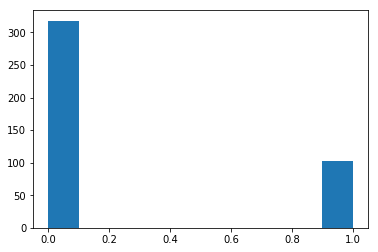

In [216]:
plt.hist(ys);

In [217]:
len(ys), len(ypred)

(420, 420)

In [218]:
print(metrics.classification_report(ys, ypred))

              precision    recall  f1-score   support

         0.0       0.75      0.88      0.81       318
         1.0       0.16      0.07      0.10       102

   micro avg       0.69      0.69      0.69       420
   macro avg       0.45      0.48      0.45       420
weighted avg       0.60      0.69      0.64       420



In [160]:
len(ypred[ypred > 0])

22

In [161]:
100*len(ypred[ypred > 0])/nmax

0.004321453265447231

In [167]:
dresults = predics_clip.copy()
dresults['ytrue'] = np.nan

In [168]:
len(ys), len(dresults)

(271, 421)

### Precision One vs All 

This precision is diferrente from the one above. 


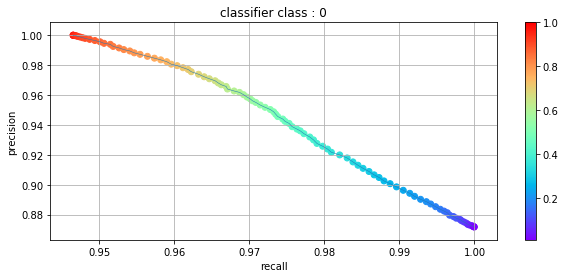

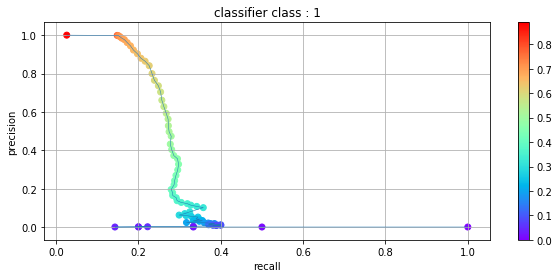

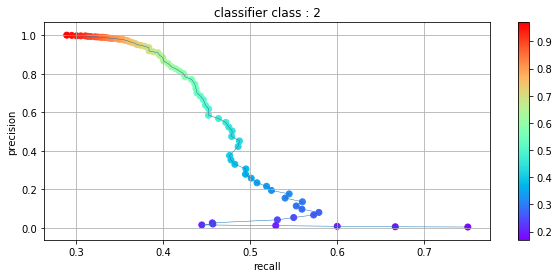

In [113]:
def plotroc(ytrue, ytest, classy):
    plt.figure(figsize=(10,4))
    prec, recall, thresholds = metrics.precision_recall_curve(ytrue, ytest)
    plt.plot(prec[:-1], recall[:-1], lw=0.5)
    plt.scatter(prec[:-1], recall[:-1], c=thresholds[::-1], cmap='rainbow')
    plt.colorbar()
    plt.rcParams['font.size'] = 10
    plt.title('classifier class : '+classy)
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.grid(True)
    #print(thresholds)

classy = dresults.copy()[['ytrue', 'y0']]
classy.loc[classy.ytrue == 0, 'ytrue'] = -999 # the 0 trues
classy.loc[classy.ytrue != -999, 'ytrue'] = 0 # what is not zero
classy.loc[classy.ytrue == -999, 'ytrue'] = 1 # set as one (binary roc)
#print(metrics.roc_auc_score(classy.ytrue, classy['y0']))
plotroc(classy.ytrue, classy['y0'], '0')
classy = dresults.copy()[['ytrue', 'y1']]
classy.loc[classy.ytrue != 1, 'ytrue'] = 0
plotroc(classy.ytrue, classy.y1, '1')
#print(metrics.roc_auc_score(classy.ytrue, classy['y1']))
classy = dresults.copy()[['ytrue', 'y2']]
classy.loc[classy.ytrue != -1, 'ytrue'] = 0 # what is not zero
classy.loc[classy.ytrue == -1, 'ytrue'] = 1 # set as one (binary roc)
plotroc(classy.ytrue, classy.y2, '2')
#print(metrics.roc_auc_score(classy.ytrue, classy['y2']))

In [ ]:
predics = predics[ predics.ypred != 0 ] 

In [ ]:
predics.ypred.hist()

In [ ]:
predics.head()

In [ ]:
pwd

In [ ]:
predics.to_pickle('last_year_daemon.pickle')

In [ ]:
import numpy as np

In [ ]:
np.ceil(94231/5.0)*5.0